In [181]:
import os.path
import time


import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , fbeta_score
import math
import tqdm
import numpy as np
import itertools
import pickle
import os
import pygad
import numexpr

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

plt.rcParams['figure.figsize'] = [15, 10]

#a = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")


### Kaggle dataset

In [7]:
test = pd.read_csv("historical_stock_prices.csv",usecols=[0,1,2,6,7],index_col=[0])

In [8]:
test['date'] = pd.to_datetime(test['date'])

poiščemo sumacijo volumna in glej po njem

In [9]:
valid_stonk = test.loc[test["date"]<"1.1.2000"].groupby("ticker").sum().index

c = test.groupby("ticker").sum()
c = c.loc[valid_stonk].sort_values(by=["volume"],ascending=False).head(100)


In [10]:
tickerji = c.index

računanje točk obrata trenda

In [11]:
#za trenirati uporabimo prvih deset let
groupe = test.groupby("ticker")
ticker400_data = {g:groupe.get_group(g) for g in groupe.groups if g in tickerji}

def trendReversals(df,percent,prevPivot = -1,sgn=None):
    #če ni prejšne regerenčne točke postavimo na prvo točko kot referenčno
    if prevPivot == -1:
        prevPivot = 0
    #resetiramo highest in lowest na prejšno referenčno točko, highest bo zvišveal prejšno referenčno točko saj le ta
    #je registrirana ko pridemo percent število procentov sstran od prejšne referenčne točke to ne pomeni da je to najvišja točka pivota
    #le da se je zamenjal trend
    highest = lowest = prevPivot
    #iteriramo skozi podatke v podatkovni monžici
    for i in range(prevPivot,len(df.index)):
        #če je trenutna točka višja od točke shranjene v highest
        if df.iloc[i]['open'] > df.iloc[highest]['open']:
            #v primeru da je bil prejšnji trend pozitiven in je definiran zvišujemo tudi lokacijo pivota saj je le ta najvišja točka pred spremembo trenda
            if sgn is not None and sgn:
                prevPivot = i
            #posodobimo vrednost highest z novo najvišjo vrednostjo
            highest = i
        #če je trenutna točka nižja od točke shranjene v lowest
        if df.iloc[i]['open'] < df.iloc[lowest]['open']:
            #če je prejšnji trend definiran in je negativen torej je pivot točka najnižja točka prejšnjega trenda in jo vsakič updatamo ko najdemo nižjo
            if sgn is not None and not sgn:
                prevPivot = i
            #posodobimo najnižjo točko vsakič ko je trenutna točka nižja
            lowest = i
        # če je prejšnji trend nedefiniran ali negativen in je trneutna točka od prejšnjega pivota(najvišje/nižje točke trenda) oddaljena za percent
        # se je trend zamenjal in sedaj iščemo novo pivot točko
        if (sgn is None or not sgn) and  abs((df.iloc[i]['open']-df.iloc[prevPivot]["open"])/df.iloc[prevPivot]["open"]) > percent:
            sgnN = True
            break
        elif (sgn is None or sgn) and  abs((df.iloc[i]['open']-df.iloc[prevPivot]["open"])/df.iloc[prevPivot]["open"]) > percent:
            sgnN = False
            break
    if  i == len(df.index)-1:
            return [prevPivot]

    return [prevPivot] + trendReversals(df,percent,prevPivot,sgnN)



testiranje zigzag

%return: (close-open)/open --> pozitiven return v primeru da je close visji

In [12]:
if os.path.isfile('./ticker400_data.pickle'):
    with open('ticker400_data.pickle', 'rb') as handle:
        ticker400_data = pickle.load(handle)
    with open('ticker400_trend15.pickle', 'rb') as handle:
        ticker400_trend15 = pickle.load(handle)
    with open('ticker400_tren10.pickle', 'rb') as handle:
        ticker400_trend10 = pickle.load(handle)
    with open('ticker400_trend20.pickle', 'rb') as handle:
        ticker400_trend20 = pickle.load(handle)
else:

    ticker400_trend10 = {}
    ticker400_trend15 = {}
    ticker400_trend20 = {}
    for t in ticker400_data:
        ticker400_data[t] = ticker400_data[t].sort_values(by=['date'])
        ticker400_data[t]["return"] = (ticker400_data[t]["open"] - ticker400_data[t].shift(1,fill_value=ticker400_data[t]['open'].iloc[0])["open"])/ticker400_data[t].shift(1, fill_value=ticker400_data[t]['open'].iloc[0])["open"]
        ticker400_data[t]["volume%"] =  (ticker400_data[t]["volume"] - ticker400_data[t].shift(1,fill_value=ticker400_data[t]['volume'].iloc[0])["volume"])/ticker400_data[t].shift(1, fill_value=ticker400_data[t]['volume'].iloc[0])["volume"]
        #delamo na vrsticah >n-1
        ticker400_data[t]["volume5%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(5).mean())/ticker400_data[t]['volume'].rolling(5).mean()
        ticker400_data[t]["volume10%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(10).mean())/ticker400_data[t]['volume'].rolling(10).mean()
        ticker400_data[t]["volume15%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(15).mean())/ticker400_data[t]['volume'].rolling(15).mean()
        ticker400_data[t]["volume20%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(20).mean())/ticker400_data[t]['volume'].rolling(20).mean()
        ticker400_trend15[t] = trendReversals(ticker400_data[t],0.15)
        ticker400_trend20[t] = trendReversals(ticker400_data[t],0.20)
        ticker400_trend10[t] = trendReversals(ticker400_data[t],0.10)
        ticker400_data[t].reset_index(drop=True,inplace=True)



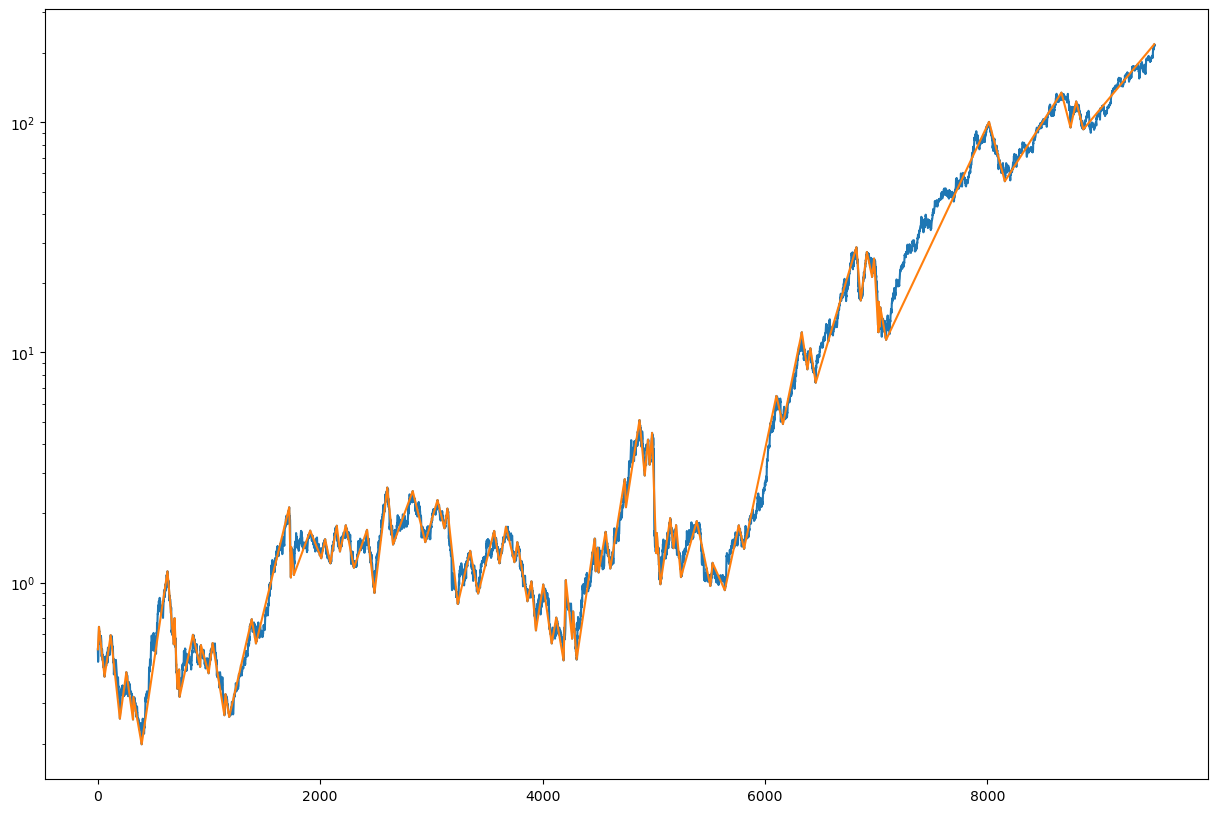

In [13]:
a = trendReversals(ticker400_data['AAPL'],0.20)
plt.plot(range(len(ticker400_data['AAPL'].index)),ticker400_data['AAPL']["open"])
plt.plot(a,ticker400_data['AAPL']["open"].iloc[a])
plt.yscale("log")
plt.show()

Damo v bool array za AUC racunat

In [14]:
ticker400_trend10B = {}
ticker400_trend15B = {}
ticker400_trend20B = {}

for t in ticker400_data:
    ticker400_trend10B[t] = pd.DataFrame(data=[False]*len(ticker400_data[t]))
    ticker400_trend10B[t].iloc[ticker400_trend10[t]] = True
    ticker400_trend15B[t] = pd.DataFrame(data=[False]*len(ticker400_data[t]))
    ticker400_trend15B[t].iloc[ticker400_trend15[t]] = True
    ticker400_trend20B[t] = pd.DataFrame(data=[False]*len(ticker400_data[t]))
    ticker400_trend20B[t].iloc[ticker400_trend20[t]] = True


In [15]:
import pickle

with open('ticker400_data.pickle', 'wb') as handle:
    pickle.dump(ticker400_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('ticker400_tren10.pickle','wb') as fp:
    pickle.dump(ticker400_trend10,fp,protocol=pickle.HIGHEST_PROTOCOL)
with open('ticker400_trend15.pickle','wb') as fp1:
    pickle.dump(ticker400_trend15,fp1,protocol=pickle.HIGHEST_PROTOCOL)
with open('ticker400_trend20.pickle','wb') as fp2:
    pickle.dump(ticker400_trend20,fp2,protocol=pickle.HIGHEST_PROTOCOL)

# Genetic algorithm

Implement a genetic algorithm that finds the optimal target, stoploss, volume,

Razdelim na test train razdelitev in poženem genetski algoritem nad tem.
opcije za split= 25% je test/50%je test in vsak mesec se doda za optimizacijo naslednga

In [16]:
splits25 = {g: train_test_split(ticker400_data[g],shuffle=False)for g in ticker400_data}
splits25_YB = {g:{10:train_test_split(ticker400_trend10B[g],shuffle=False),15:train_test_split(ticker400_trend15B[g],shuffle=False),20:train_test_split(ticker400_trend20B[g],shuffle=False)} for g in ticker400_data}
#splits50rolling = {g: train_test_split(ticker400_data[g], train_size=0.5,shuffle=False)for g in ticker400_data}
splits50rolling = {}

na podlagi teh podatkov, ki jih imam sestavimo opcijo različnega zmaika podatkov, različnega števila vštetih dni[1-7]

spremenljivke:
-doba filtrove porazdelitve za oceno odstopanja za volumen
-doba filtrove porazdelitve za oceno odstopanja za povračilo
-kje izstopiti iz trada
-kje ugotoviti če je trade napačen*


In [17]:
#splits25['AAPL'][0][3:][splits25['AAPL'][0]["return"]>0.1 and splits25['AAPL'][0]["return"]>0.1].index

In [18]:
def find_intersect_2_ordered_lists(list1,list2):
    li2=li1=0
    intersect = []
    if list1 is None or list2 is None or len(list1) == 0 or len(list2)==0 :
        return []
    while True:
        if list1[li1] == list2[li2]:
            intersect.append(list1[li1])
            li1 = li1 + 1
            li2 = li2 + 1
        elif list1[li1] < list2[li2]:
            li1 = li1 + 1
        else:
            li2 = li2 + 1
        if li1 == len(list1) or li2 == len(list2):
            return intersect

def all_true(truers):
    ret = True
    for j in truers:
        if not j:
            return False
    return True

def combine_lists(lists):
    idxs = [0 for l in lists]
    lens = [len(l) for l in lists]
    comb = []
    while True:
        if all_true([l == k for (l,k) in zip(idxs,lens)]):
            return comb
        cur = idxs.index(min(idxs))


In [19]:
def fit_params_AUC(df,dfY,tick,percent):

    def fit_me_AUC(solution, index):
        #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
        if solution[0] <= -1 or solution[1] <= -1 or solution[2] <= -1 or solution[3] <= -1 or solution[4] < 0 or solution[5] < 0 or solution[6] < 0 or solution[7] < 0:
            return -10000000000
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[2]
        volFDown = solution[3]
        fit = 0
        lfRUp = list(df[tick][0][df[tick][0]["return"]>retFUp].index + math.floor(solution[4]))
        lfRDw = list(df[tick][0][df[tick][0]["return"]>retFDown].index + math.floor(solution[6]))
        lfVUp = list(df[tick][0][df[tick][0]["volume%"]>volFUp].index + math.floor(solution[5]))
        lfVDw = list(df[tick][0][df[tick][0]["volume%"]>volFDown].index + math.floor(solution[7]))



        res= pd.DataFrame(data=[False]*len(df[tick][0]))
        up = list(find_intersect_2_ordered_lists(lfVUp,lfRUp))
        cut = 0
        for k in reversed(up):
            if k < len(df[tick][0]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][0]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][0],res)
    return fit_me_AUC

In [20]:
def fit_params_AUC_lagged(df,dfY,tick,percent,n_lagged = 1):
    def fita(solution, index):
        #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
        if solution[0] <= -1 or solution[1] <= -1 or solution[2] <= -1 or solution[3] <= -1 or solution[4] < 0 or solution[5] < 0 or solution[6] < 0 or solution[7] < 0:
            return -10000000000
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[2]
        volFDown = solution[3]
        fit = 0
        lfRUp = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:]["return"]>retFUp].index + math.floor(solution[4]))
        lfRDw = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:]["return"]>retFDown].index + math.floor(solution[6]))
        lfVUp = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:][col]>volFUp].index + math.floor(solution[5]))
        lfVDw = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:][col]>volFDown].index + math.floor(solution[7]))



        res= pd.DataFrame(data=[False]*len(df[tick][0][n_lagged-1:]))
        up = list(find_intersect_2_ordered_lists(lfVUp,lfRUp))
        cut = 0
        for k in reversed(up):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][0][n_lagged-1:],res)
    return fita

In [21]:
def fit_params_AUC_lagged_combinedOR(df,dfY,tick,percent,n_lagged = 20):
    def fita(solution, index):
        #24 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW]
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[6]
        volFDown = solution[7]
        fit = 0
        l_UP = []
        l_DW = []
        buildingblocksUP = []
        buildingblocksDW = []
        test = df[tick][0][n_lagged-1:]
        up = test.loc[(test['return'].shift(math.floor(solution[12])) > solution[0]) |
                      (test['volume%'].shift(math.floor(solution[13])) > solution[1]) |
                       (test['volume5%'].shift(math.floor(solution[14])) > solution[2]) |
                        (test['volume10%'].shift(math.floor(solution[15])) > solution[3]) |
                         (test['volume15%'].shift(math.floor(solution[16])) > solution[4]) |
                          (test['volume20%'].shift(math.floor(solution[17])) > solution[5])
                        ].index
        down = test.loc[(test['return'].shift(math.floor(solution[18])) > solution[6]) |
        (test['volume%'].shift(math.floor(solution[19])) > solution[7]) |
        (test['volume5%'].shift(math.floor(solution[20])) > solution[8]) |
        (test['volume10%'].shift(math.floor(solution[21])) > solution[9]) |
        (test['volume15%'].shift(math.floor(solution[22])) > solution[10]) |
        (test['volume20%'].shift(math.floor(solution[23])) > solution[11])
                        ].index


        res= pd.DataFrame(data=[False]*len(df[tick][0][n_lagged-1:]))

        cut = 0
        for k in reversed(up):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        #down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][0][n_lagged-1:],res)
    return fita


In [22]:
def fit_params_AUC_lagged_combinedOR_test(df,dfY,tick,percent,n_lagged = 20):
    def fita(solution, index):
        #24 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW]
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[6]
        volFDown = solution[7]
        fit = 0
        l_UP = []
        l_DW = []
        buildingblocksUP = []
        buildingblocksDW = []
        test = df[tick][1][n_lagged-1:]
        up = test.loc[(test['return'].shift(math.floor(solution[12])) > solution[0]) |
                      (test['volume%'].shift(math.floor(solution[13])) > solution[1]) |
                       (test['volume5%'].shift(math.floor(solution[14])) > solution[2]) |
                        (test['volume10%'].shift(math.floor(solution[15])) > solution[3]) |
                         (test['volume15%'].shift(math.floor(solution[16])) > solution[4]) |
                          (test['volume20%'].shift(math.floor(solution[17])) > solution[5])
                        ].index
        down = test.loc[(test['return'].shift(math.floor(solution[18])) > solution[6]) |
        (test['volume%'].shift(math.floor(solution[19])) > solution[7]) |
        (test['volume5%'].shift(math.floor(solution[20])) > solution[8]) |
        (test['volume10%'].shift(math.floor(solution[21])) > solution[9]) |
        (test['volume15%'].shift(math.floor(solution[22])) > solution[10]) |
        (test['volume20%'].shift(math.floor(solution[23])) > solution[11])
                        ].index


        res= pd.DataFrame(data=[False]*len(df[tick][1][n_lagged-1:]))

        cut = 0
        for k in reversed(up):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        #down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

In [23]:
def fit_me10_all(solution,index):
    #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
    if solution[0] <= -1 or solution[1] <= -1 or solution[2] <= -1 or solution[3] <= -1 or solution[4] < 0 or solution[5] < 0 or solution[6] < 0 or solution[7] < 0:
        return -10000000000
    #dodal bomo še kako se filtre združuje skupi z or ali and!

    retFUp = solution[0]
    volFUp = solution[1]
    retFDown = solution[2]
    volFDown = solution[3]
    fit = 0
    #print(solution.dtype)
    #nima smisla da je en pred pivotom za vrh manjši kot za dolino saj more bit return change negativen za dolino in pozitiven za vrh
    if retFUp<= retFDown:
        return -10000000000
    for tick in splits25:
        #ret filter
        #lahko še naredimo da je variable kolk prej rab se zgodit filter

        lfRUp = list(splits25[tick][0][splits25[tick][0]["return"]>retFUp].index + math.floor(solution[4]))
        lfRDw = list(splits25[tick][0][splits25[tick][0]["return"]>retFDown].index + math.floor(solution[6]))
        lfVUp = list(splits25[tick][0][splits25[tick][0]["volume%"]>volFUp].index + math.floor(solution[5]))
        lfVDw = list(splits25[tick][0][splits25[tick][0]["volume%"]>volFDown].index + math.floor(solution[7]))
        #print(len(lfRUp),len(lfRDw),len(lfVUp),len(lfVDw))
        up = set(find_intersect_2_ordered_lists(lfVUp,lfRUp))
        down = set(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        comb = list(up.union(down)).sort()


        zadetkov = len(find_intersect_2_ordered_lists(comb,ticker400_trend10[tick]))
        zgresenih = (len(comb) if comb else 0 )- zadetkov
        if comb is None:
            fit = fit -100000
        else:
            fit = fit + zadetkov - zgresenih

    return fit


In [24]:
def fit_params_AUC_lagged_combined_special(df,dfY,tick,percent,n_lagged = 20):
    def fita(solution, index):
        #24 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[6]
        volFDown = solution[7]
        fit = 0
        l_UP = []
        l_DW = []
        buildingblocksUP = []
        buildingblocksDW = []
        test = df[tick][1][n_lagged-1:]
        up = test.loc[(test['return'].shift(math.floor(solution[12])) > solution[0]) |
                      (test['volume%'].shift(math.floor(solution[13])) > solution[1]) |
                       (test['volume5%'].shift(math.floor(solution[14])) > solution[2]) |
                        (test['volume10%'].shift(math.floor(solution[15])) > solution[3]) |
                         (test['volume15%'].shift(math.floor(solution[16])) > solution[4]) |
                          (test['volume20%'].shift(math.floor(solution[17])) > solution[5])
                        ].index
        down = test.loc[(test['return'].shift(math.floor(solution[18])) > solution[6]) |
        (test['volume%'].shift(math.floor(solution[19])) > solution[7]) |
        (test['volume5%'].shift(math.floor(solution[20])) > solution[8]) |
        (test['volume10%'].shift(math.floor(solution[21])) > solution[9]) |
        (test['volume15%'].shift(math.floor(solution[22])) > solution[10]) |
        (test['volume20%'].shift(math.floor(solution[23])) > solution[11])
                        ].index


        res= pd.DataFrame(data=[False]*len(df[tick][1][n_lagged-1:]))

        cut = 0
        for k in reversed(up):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        #down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

opcija odkrivanja točk obrata

In [25]:
"""
with tqdm.tqdm(total=100) as pbar:
    gen10 = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_me10_all,sol_per_pop=50,num_genes=8,init_range_low=-1)
    gen10.run()"""

'\nwith tqdm.tqdm(total=100) as pbar:\n    gen10 = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_me10_all,sol_per_pop=50,num_genes=8,init_range_low=-1)\n    gen10.run()'

## Ugotovitve
- zmanjšat mormo število tickerjev ker je zadeva čist prepočasna
- statičn velik preskok ne naredi velik

In [26]:
"""num = 0
sols = {}
for tick in list(ticker400_data.keys()):
    print("Currently working on: " + tick + " " + str(num))
    num = num + 1
    #fit = fit_params_AUC(splits25,splits25_YB,tick,10)
    #print(fit)
    sols[tick] = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_params_AUC(splits25,splits25_YB,tick,10),sol_per_pop=50,num_genes=8,init_range_low=-1,suppress_warnings=True,save_best_solutions=True)
    sols[tick].run()
    print(sols[tick].best_solutions)"""

'num = 0\nsols = {}\nfor tick in list(ticker400_data.keys()):\n    print("Currently working on: " + tick + " " + str(num))\n    num = num + 1\n    #fit = fit_params_AUC(splits25,splits25_YB,tick,10)\n    #print(fit)\n    sols[tick] = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_params_AUC(splits25,splits25_YB,tick,10),sol_per_pop=50,num_genes=8,init_range_low=-1,suppress_warnings=True,save_best_solutions=True)\n    sols[tick].run()\n    print(sols[tick].best_solutions)'

Lagged

In [27]:
"""num = 0
sols_lagged = {k: {} for k in [1,5,10,15,20]}
for tick in list(ticker400_data.keys()):
    for lag in [1,5,10,15,20]:
        print("Currently working on: " + tick + " " + str(num))
        print("Lag: " + str(lag))
        num = num + 1
        #fit = fit_params_AUC(splits25,splits25_YB,tick,10)
        #print(fit)
        sols_lagged[lag][tick] = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_params_AUC_lagged(splits25,splits25_YB,tick,10,lag),sol_per_pop=50,num_genes=8,init_range_low=-1,suppress_warnings=True,save_best_solutions=True)
        sols_lagged[lag][tick].run()
        print(sols_lagged[lag][tick].best_solutions[-1],sols_lagged[lag][tick].best_solutions_fitness[-1])"""

'num = 0\nsols_lagged = {k: {} for k in [1,5,10,15,20]}\nfor tick in list(ticker400_data.keys()):\n    for lag in [1,5,10,15,20]:\n        print("Currently working on: " + tick + " " + str(num))\n        print("Lag: " + str(lag))\n        num = num + 1\n        #fit = fit_params_AUC(splits25,splits25_YB,tick,10)\n        #print(fit)\n        sols_lagged[lag][tick] = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_params_AUC_lagged(splits25,splits25_YB,tick,10,lag),sol_per_pop=50,num_genes=8,init_range_low=-1,suppress_warnings=True,save_best_solutions=True)\n        sols_lagged[lag][tick].run()\n        print(sols_lagged[lag][tick].best_solutions[-1],sols_lagged[lag][tick].best_solutions_fitness[-1])'

test solutions on test data

Združeni lagged filtri različni

In [28]:
"""num = 0
sols_filterORx2 = {k: {} for k in [10,15,20]}
for tick in list(ticker400_data.keys()):
    print("Currently working on: " + tick + " " + str(num))
    for percent in [10,15,20]:
        print("Percent: " + str(percent))
        sols_filterORx2[percent][tick] = pygad.GA(num_generations=250,num_parents_mating=10,fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,tick,percent),sol_per_pop=50,num_genes=24,init_range_low=-1,suppress_warnings=True,save_best_solutions=True,stop_criteria='saturate_7')
        sols_filterORx2[percent][tick].run()
        print(sols_filterORx2[percent][tick].best_solutions[-1],sols_filterORx2[percent][tick].best_solutions_fitness[-1])
    num = num + 1"""

'num = 0\nsols_filterORx2 = {k: {} for k in [10,15,20]}\nfor tick in list(ticker400_data.keys()):\n    print("Currently working on: " + tick + " " + str(num))\n    for percent in [10,15,20]:\n        print("Percent: " + str(percent))\n        sols_filterORx2[percent][tick] = pygad.GA(num_generations=250,num_parents_mating=10,fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,tick,percent),sol_per_pop=50,num_genes=24,init_range_low=-1,suppress_warnings=True,save_best_solutions=True,stop_criteria=\'saturate_7\')\n        sols_filterORx2[percent][tick].run()\n        print(sols_filterORx2[percent][tick].best_solutions[-1],sols_filterORx2[percent][tick].best_solutions_fitness[-1])\n    num = num + 1'

Testiranje najboljših parametrov ga

In [29]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
count = 0
pos = 0
if os.path.isfile('./eval1.pkl'):
    ga_evaluation = pd.read_pickle('./eval1.pkl')
    with open('pos.pickle', 'rb') as handle:
        pos = pickle.load(handle)
else:
    ga_evaluation = pd.DataFrame(columns=['St. gen', 'St. starsev','Velikost pop','Izbira starsev','K Turnir','Tip križanja','Tip muaticje','Mutacija z zamenjavo','Ustavitveni pogoj','AUC','Trajanje'])

t = c.head(1).index.values[0]
num_generations = [10,50]
num_parents_mating = [0.005,0.05,0.1,0.25,0.5]
sol_per_pop = [10,20,40,80,160,320]
#[retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW]
num_genes = 24
#!!!!!
gene_type = [np.float16 for x in range(12)]+[np.uint8 for x in range(12)]
init_range_low = -1
init_range_high = 8
parent_selection = ['sss','rws','sus','rank','random','tournament']
#if tournament
k_tournament = [0.05,0.1,0.15,0.2,0.4,0.5,0.6,0.7]
crossover_tip = ['single_point','two_points','uniform','scattered']
mutation_type=['random','swap','inversion','scramble',None]
#if mutation type random
mutation_by_replacement = [True,False]
#!!!!!
gene_space = [{'low':-1,'high':8} for x in range(12)]+[[y for y in range(20)] for j in range(12)]
save_best_solutions = True
suppress_warnings = True
stop_criteria = ['saturate_5','saturate_7','saturate_9','saturate_12','saturate_15',]

comb = list(itertools.product(num_generations,num_parents_mating,sol_per_pop,parent_selection,k_tournament,crossover_tip,mutation_type,mutation_by_replacement,stop_criteria))
print(len(comb))
print(pos)
#testiran bo za 10
for a in comb:
    if count <= pos and pos != 0 or (a[2] <= 20 and a[1] == 0.05):
        #if count % 100:
            #print("running" + str(count))
        count = count + 1
        continue
    start = datetime.datetime.now()

    if count%100 == 0:
        print(count)
    if(a[3] == 'tournament'):
        if(a[6] == 'random'):
            #print("hello")
            ins = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=a[0],num_parents_mating=math.ceil(a[1]*a[2]),fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,10),sol_per_pop=a[2],parent_selection_type=a[3],K_tournament=math.ceil(a[4]*(math.ceil(a[1]*a[2]))),crossover_type=a[5],mutation_type=a[6],mutation_by_replacement=a[7],stop_criteria=a[8])
            ins.run()
            end = datetime.datetime.now()
            ga_evaluation = ga_evaluation.append({'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start},ignore_index=True)
        else:
            if(a[7]):
                ins = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=a[0],num_parents_mating=math.ceil(a[1]*a[2]),fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,10),sol_per_pop=a[2],parent_selection_type=a[3],K_tournament=math.ceil(a[4]*(math.ceil(a[1]*a[2]))),crossover_type=a[5],mutation_type=a[6],mutation_by_replacement=a[7],stop_criteria=a[8])
                ins.run()
                end = datetime.datetime.now()
                ga_evaluation = ga_evaluation.append({'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start},ignore_index=True)
    else:
        if(a[4] == 0.05):
            if(a[6] == 'random'):
                ins = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=a[0],num_parents_mating=math.ceil(a[1]*a[2]),fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,10),sol_per_pop=a[2],parent_selection_type=a[3],K_tournament=math.ceil(a[4]*(math.ceil(a[1]*a[2]))),crossover_type=a[5],mutation_type=a[6],mutation_by_replacement=a[7],stop_criteria=a[8])
                ins.run()
                end = datetime.datetime.now()
                ga_evaluation = ga_evaluation.append({'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start},ignore_index=True)
            else:
                if(a[7]):
                    ins = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=a[0],num_parents_mating=math.ceil(a[1]*a[2]),fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,10),sol_per_pop=a[2],parent_selection_type=a[3],K_tournament=math.ceil(a[4]*(math.ceil(a[1]*a[2]))),crossover_type=a[5],mutation_type=a[6],mutation_by_replacement=a[7],stop_criteria=a[8])
                    ins.run()
                    end = datetime.datetime.now()
                    ga_evaluation = ga_evaluation.append({'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start},ignore_index=True)
    count = count+1
    gene_type = [np.float16 for x in range(12)]+[np.uint8 for x in range(12)]
    if count % 100 == 0 and ins is not None:
        pd.to_pickle(ga_evaluation,'./eval1.pkl')
        with open('pos.pickle', 'wb') as handle:
            pickle.dump(count, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(count)
pd.to_pickle(ga_evaluation,'./eval1.pkl')


576000
576000
576000


poiščemo top 10 kompozicij po AUC-ju

In [30]:
duration = 4  # seconds
freq = 440  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

1

In [31]:
ga_evaluation.sort_values(by='AUC',ascending=False).head(10)
#tip mutacije je najbolš random
#izbira starsev je sss ali rank mogoče tudi tournament
#st starsev ne rabi biti pretirano veliko za sss in rank

,St. gen,St. starsev,Velikost pop,Izbira starsev,K Turnir,Tip križanja,Tip muaticje,Mutacija z zamenjavo,Ustavitveni pogoj,AUC,Trajanje
51898,50,2,320,rank,1,uniform,random,True,saturate_12,0.615,0 days 00:01:07.169492
77931,50,80,320,tournament,56,uniform,random,True,saturate_15,0.613,0 days 00:00:55.163816
57804,50,16,320,sss,1,scattered,random,True,saturate_7,0.613,0 days 00:01:01.964698
87076,50,160,320,tournament,80,scattered,random,True,saturate_7,0.612,0 days 00:00:48.066029
58168,50,16,320,rank,1,scattered,random,False,saturate_5,0.612,0 days 00:01:03.558186
57714,50,16,320,sss,1,single_point,random,True,saturate_7,0.611,0 days 00:01:03.351108
57811,50,16,320,sss,1,scattered,random,False,saturate_12,0.611,0 days 00:01:03.281494
51932,50,2,320,rank,1,scattered,random,False,saturate_9,0.61,0 days 00:01:06.671907
77747,50,80,320,tournament,48,single_point,random,True,saturate_5,0.61,0 days 00:00:47.691477
49920,50,1,160,sss,1,single_point,random,False,saturate_5,0.609,0 days 00:00:29.041797


In [32]:
best =#{'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start
res = {t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}
for t in list(ticker400_data):
    for percent in [10,15,20]:
        res[t][percent]['train'] = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=ga_evaluation.loc["St. gen"],num_parents_mating=ga_evaluation.loc["St. starsev"],fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,percent),sol_per_pop=best.loc["Velikost pop"],parent_selection_type=best.loc["Izbira starsev"],K_tournament=best.loc["K Turnir"],crossover_type=best.loc["Tip križanja"],mutation_type=best.loc["Tip muaticje"],mutation_by_replacement=best.loc["Mutacija z zamenjavo"],stop_criteria=best.loc["Ustavitveni pogoj"])
        res[t][percent]['train'].run()
        res[t][percent]['test'] = fit_params_AUC_lagged_combinedOR_test(splits25,splits25_YB,t,percent)(res[t][percent]['train'].best_solutions[-1],0)



SyntaxError: invalid syntax (712243466.py, line 1)

Grafikoni evalvacije

AUC za celotn ansambl delnic

In [178]:
def fit_params_AUC_lagged_combined_special(df,dfY,tick,percent,n_lagged = 20,sty=0,metric=roc_auc_score, beta = -1):
    def fita(solution, index):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'

        test = df[tick][0][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()
        if sty == 0:
            u0 = ' | ' if solution[36] else ' & '
            u1 = ' | ' if solution[37] else ' & '
            u2 = ' | ' if solution[38] else ' & '
            u3 = ' | ' if solution[39] else ' & '
            u4 = ' | ' if solution[40] else ' & '

            connec = ' | ' if solution[-1] else ' & '

            d0 = ' | ' if solution[41] else ' & '
            d1 = ' | ' if solution[42] else ' & '
            d2 = ' | ' if solution[43] else ' & '
            d3 = ' | ' if solution[44] else ' & '
            d4 = ' | ' if solution[45] else ' & '
            q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
                '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
                '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
                '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
                '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
                '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
                connec +
                '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
                '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
                '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
                '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
                '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
                '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')

            up = test.query(q).index
            #print(up)

            res = np.array([False]*len(test))
            #print(len(res))
            res[up] =True
        else:

            up = [np.array([False]*len(df[tick][1][n_lagged-1:])) for i in range(6)]
            down = [np.array([False]*len(df[tick][1][n_lagged-1:]))*6 for i in range(6)]
            eval_stringu = ""
            eval_stringd = ""
            for i in range(6):
                idxu =test.loc[(test[col_names[i]].shift(solution[i+12]) > solution[i])].index - test[col_names[i]].shift(solution[i+12]).index[0]
                #print(idxu)
                up[i][idxu] = True
                idxd = test.loc[(test[col_names[i]].shift(solution[i+18]) > solution[i+6])].index - test[col_names[i]].shift(solution[i+18]).index[0]
                #print(down[i])
                down[i][idxd] = True

            for i in range(5):
                eval_stringu = f"{eval_stringu}{'np.logical_or' if solution[i+36] else 'np.logical_and'}(up[posu[{i}]], "
                eval_stringd = f"{eval_stringd}{'np.logical_or' if solution[i+41] else 'np.logical_and'}(down[posd[{i}]], "
            eval_stringu = f"{eval_stringu}up[posu[5]] )))))"
            #print(eval_stringu)
            eval_stringd = f"{eval_stringd}down[posd[5]] )))))"
            #print(eval_stringd)
            #np.logical_or(np.logical_and(up[posu[0]], np.logical_or(up[posu[1]], np.logical_or(up[posu[2]], np.logical_and(up[posu[3]], np.logical_and(up[posu[4]], up[posu[5]] ))))),np.logical_and(up[posu[0]], np.logical_or(up[posu[1]], np.logical_or(up[posu[2]], np.logical_and(up[posu[3]], np.logical_and(up[posu[4]], np.logical_and(up[posd[4]], down[posd[5]] )))))))
            res = eval(f"{'np.logical_or' if solution[-1] else 'np.logical_and'}({eval_stringu},{eval_stringd})")

        #print(roc_auc_score(dfY[tick][percent][0],res))
        if(beta != -1):
            return metric(dfY[tick][percent][0][n_lagged-1:],res,beta=beta)
        return metric(dfY[tick][percent][0][n_lagged-1:],res)
    return fita

In [188]:
def fit_params_AUC_lagged_combined_special_test(df,dfY,tick,percent,n_lagged = 20,sty=0,metric=roc_auc_score, beta=-1):
    def fita(solution, index):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]


        test = df[tick][1][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()
        if sty == 0:
            u0 = ' | ' if solution[36] else ' & '
            u1 = ' | ' if solution[37] else ' & '
            u2 = ' | ' if solution[38] else ' & '
            u3 = ' | ' if solution[39] else ' & '
            u4 = ' | ' if solution[40] else ' & '

            connec = ' | ' if solution[-1] else ' & '

            d0 = ' | ' if solution[41] else ' & '
            d1 = ' | ' if solution[42] else ' & '
            d2 = ' | ' if solution[43] else ' & '
            d3 = ' | ' if solution[44] else ' & '
            d4 = ' | ' if solution[45] else ' & '
            q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
                '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
                '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
                '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
                '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
                '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
                connec +
                '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
                '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
                '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
                '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
                '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
                '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')

            up = test.query(q).index
            res = np.array([False]*len(df[tick][1][n_lagged-1:]))
            res[up] =True
        else:

            up = [np.array([False]*len(df[tick][1][n_lagged-1:])) for i in range(6)]
            down = [np.array([False]*len(df[tick][1][n_lagged-1:]))*6 for i in range(6)]
            eval_stringu = ""
            eval_stringd = ""
            for i in range(6):
                idxu =test.loc[(test[col_names[i]].shift(solution[i+12]) > solution[i])].index - test[col_names[i]].shift(solution[i+12]).index[0]
                #print(idxu)
                up[i][idxu] = True
                idxd = test.loc[(test[col_names[i]].shift(solution[i+18]) > solution[i+6])].index - test[col_names[i]].shift(solution[i+18]).index[0]
                #print(down[i])
                down[i][idxd] = True

            for i in range(5):
                eval_stringu = f"{eval_stringu}{'np.logical_or' if solution[i+36] else 'np.logical_and'}(up[posu[{i}]], "
                eval_stringd = f"{eval_stringd}{'np.logical_or' if solution[i+41] else 'np.logical_and'}(down[posd[{i}]], "
            eval_stringu = f"{eval_stringu}up[posu[5]] )))))"
            #print(eval_stringu)
            eval_stringd = f"{eval_stringd}down[posd[5]] )))))"
            #print(eval_stringd)
            #np.logical_or(np.logical_and(up[posu[0]], np.logical_or(up[posu[1]], np.logical_or(up[posu[2]], np.logical_and(up[posu[3]], np.logical_and(up[posu[4]], up[posu[5]] ))))),np.logical_and(up[posu[0]], np.logical_or(up[posu[1]], np.logical_or(up[posu[2]], np.logical_and(up[posu[3]], np.logical_and(up[posu[4]], np.logical_and(up[posd[4]], down[posd[5]] )))))))
            res = eval(f"{'np.logical_or' if solution[-1] else 'np.logical_and'}({eval_stringu},{eval_stringd})")


        #print(roc_auc_score(dfY[tick][percent][0],res))
        if(beta != -1):
            return metric(dfY[tick][percent][1][n_lagged-1:],res,beta=beta)
        return metric(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

testing other metrics on AABA:
f0.5

In [196]:
gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30

if os.path.isfile('./test_results100.pkl'):
    with open('test_results100.pkl', 'rb') as handle:
        print("work")
        res_test = pickle.load(handle)
else:
    res_test =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}


t = 'AABA'
percent = 15
for t in list(ticker400_data):
    print(t)
    for percent in [10,15]:
        q = res_test.loc[(res_test['Ticker'] == t)& ( res_test['Percent'] ==percent),'Test_AUC']
        print(q)
        if len(q.index)>0 and not pd.isna(q.values[0]):
            print("huh")
            continue
        print(percent)
        gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_params_AUC_lagged_combined_special(splits25,splits25_YB,t,percent,sty=0,metric=fbeta_score,beta=0.5),sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False)
        cur.run()
        besto = cur.best_solution(pop_fitness=None)
        res_test = res_test.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
        res_test.loc[(res_test['Ticker'] == t)& ( res_test['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0,metric=fbeta_score,beta=0.5)(besto[0],0)


In [36]:
pd.options.mode.chained_assignment = None  # default='warn'

gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30


if os.path.isfile('./results100.pkl'):
    with open('results100.pkl', 'rb') as handle:
        print("work")
        res = pickle.load(handle)
else:
    res =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}


for t in list(ticker400_data):
    print(t)
    for percent in [10,15,20]:
        q = res.loc[(res['Ticker'] == t)& ( res['Percent'] ==percent),'Test_AUC']
        print(q)
        if len(q.index)>0 and not pd.isna(q.values[0]):
            print("huh")
            continue
        print(percent)
        gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_params_AUC_lagged_combined_special(splits25,splits25_YB,t,percent,sty=0),sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False)
        cur.run()
        besto = cur.best_solution(pop_fitness=None)
        res = res.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
        res.loc[(res['Ticker'] == t)& ( res['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0)(besto[0],0)
        res.to_pickle('./results100.pkl')

work
AABA
0    0.579
Name: Test_AUC, dtype: object
huh
1    0.556
Name: Test_AUC, dtype: object
huh
2    0.56
Name: Test_AUC, dtype: object
huh
AAPL
3    0.607
Name: Test_AUC, dtype: object
huh
4    0.659
Name: Test_AUC, dtype: object
huh
5    0.63
Name: Test_AUC, dtype: object
huh
ABT
6    0.529
Name: Test_AUC, dtype: object
huh
7    0.5
Name: Test_AUC, dtype: object
huh
8    0.502
Name: Test_AUC, dtype: object
huh
ABX
9    0.553
Name: Test_AUC, dtype: object
huh
10    0.528
Name: Test_AUC, dtype: object
huh
11    0.576
Name: Test_AUC, dtype: object
huh
ADBE
12    0.614
Name: Test_AUC, dtype: object
huh
13    0.658
Name: Test_AUC, dtype: object
huh
14    0.424
Name: Test_AUC, dtype: object
huh
AMAT
15    0.582
Name: Test_AUC, dtype: object
huh
16    0.584
Name: Test_AUC, dtype: object
huh
17    0.561
Name: Test_AUC, dtype: object
huh
AMD
18    0.525
Name: Test_AUC, dtype: object
huh
19    0.526
Name: Test_AUC, dtype: object
huh
20    0.653
Name: Test_AUC, dtype: object
huh
AMGN
21    

In [166]:
duration = 4  # seconds
freq = 440  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))




1

In [ ]:
#res.set_index(['Ticker','Percent'],inplace=True)

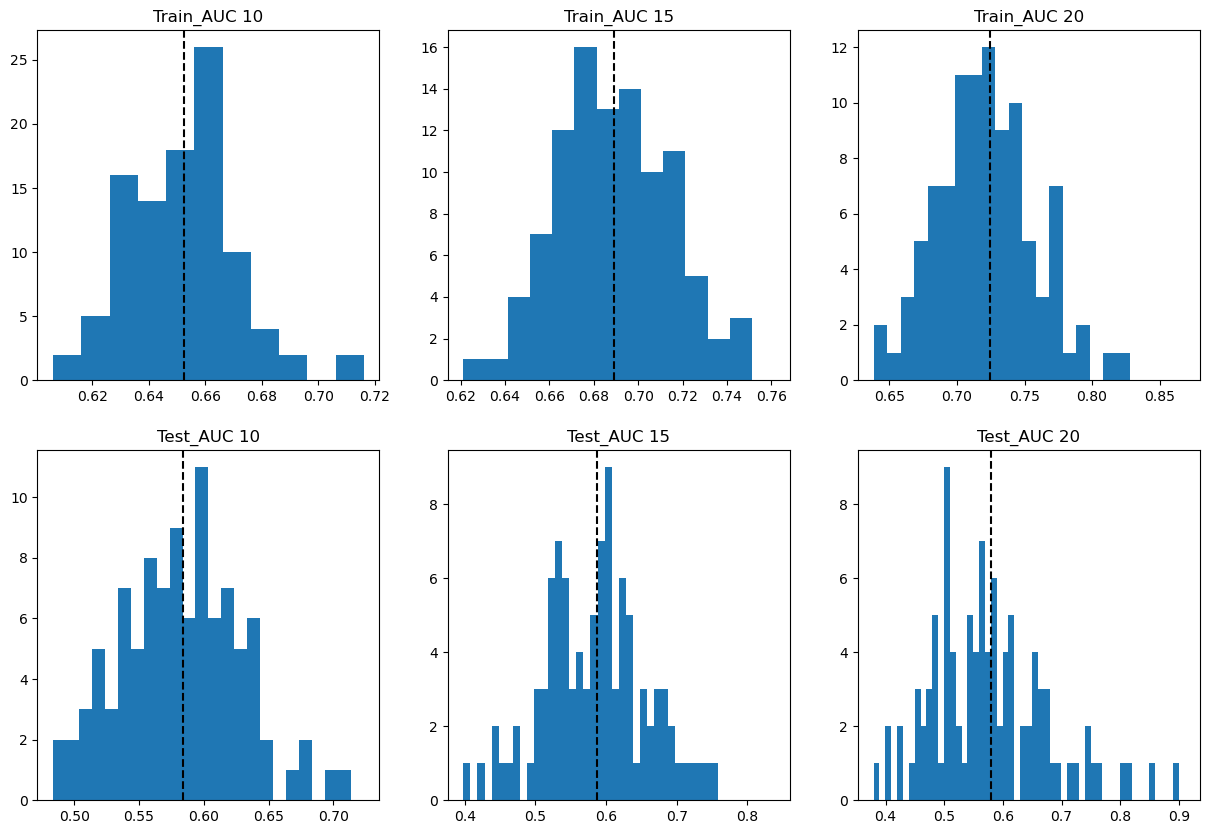

In [37]:
#len(res.loc[res['Percent'] == 10])
fix, ax = plt.subplots(2,3,figsize=(15,10))
bins = np.arange(0,1,0.001)
r = 0
c = 0
for s in ['Train_AUC','Test_AUC']:
    for i in [10,15,20]:
        #print(hist(res.loc[res['Percent'] == i][s])
        ax[r,c].hist(res.loc[res['Percent'] == i][s],np.arange(res.loc[res['Percent'] == i][s].min(),res.loc[res['Percent'] == i][s].max(),0.01))
        ax[r,c].axvline(res.loc[res['Percent'] == i][s].mean(), color='k',linestyle='dashed')
        ax[r,c].set_title(s + ' ' + str(i))
        c = c + 1
    r = r + 1
    c = 0


# Pregledovanje investiranja portfelija --> trgovanje, primerjamo z buy and hold
# Primerjava dveh strategij

In [157]:
def combined_filter_strategy(solution,start_date,df,n_lagged = 20):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        #n_lagged tells us how much history we need prior to the investment
        start_buffer = start_date - datetime.timedelta(days=n_lagged)

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################
        print(solution)
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1


        test = df.loc[df["date"]>start_buffer]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()

        u0 = ' | ' if solution[36] else ' & '
        u1 = ' | ' if solution[37] else ' & '
        u2 = ' | ' if solution[38] else ' & '
        u3 = ' | ' if solution[39] else ' & '
        u4 = ' | ' if solution[40] else ' & '

        connec = ' | ' if solution[-1] else ' & '

        d0 = ' | ' if solution[41] else ' & '
        d1 = ' | ' if solution[42] else ' & '
        d2 = ' | ' if solution[43] else ' & '
        d3 = ' | ' if solution[44] else ' & '
        d4 = ' | ' if solution[45] else ' & '
        q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
            '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
            '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
            '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
            '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
            '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
            connec +
            '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
            '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
            '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
            '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
            '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
            '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')


        print(len(test))
        up = test.query(q).index
        #res = np.array([False]*len(test))
        #res[up] =True

        #returns pivot points so points where price supposedly took a turn
        return up

In [158]:
#testing function above
combined_filter_strategy(res.loc[(res["Ticker"] == "AABA") & (res["Percent"] == 10)]['Train_solution'].iloc[0],ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date,ticker400_data['AABA'],n_lagged = 20)

[-0.0247 1.0582 2.0875 0.7048 3.5728 0.8289 -0.0714 4.8204 6.5982 4.0936
 -0.6009 7.1846 0 10 9 1 19 10 1 19 8 6 19 16 3 2 4 2 2 1 0 3 5 0 2 5 1 1
 1 0 1 0 0 0 0 0 1]
5570


Int64Index([  19,   21,   22,   23,   24,   25,   26,   29,   30,   32,
            ...
            5550, 5551, 5553, 5554, 5556, 5563, 5564, 5565, 5568, 5569], dtype='int64', length=1493)

[0.1935 4.3973 1.3456 1.3403 1.2973 -0.1047 5.8858 7.5026 -0.4415 1.8911
 3.1562 -0.7721 12 5 7 7 18 0 17 1 10 7 2 1 4 0 5 3 5 4 3 5 2 5 0 5 1 1 1
 1 1 0 1 0 0 0 0]
5570
[-0.1347 -0.3427 1.2768 1.2473 4.1682 2.4003 5.1629 6.9822 -0.6062 2.88
 -0.0611 1.201 0 1 10 1 19 16 4 7 11 5 2 15 1 4 3 0 3 5 1 5 0 3 1 1 1 0 1
 1 1 1 0 0 0 0 0]
5570
Int64Index([149, 329, 541, 567, 604, 638, 699, 951, 1076, 1079, 1123, 1137, 1312, 1499, 1509, 2973, 3113, 4812], dtype='int64')


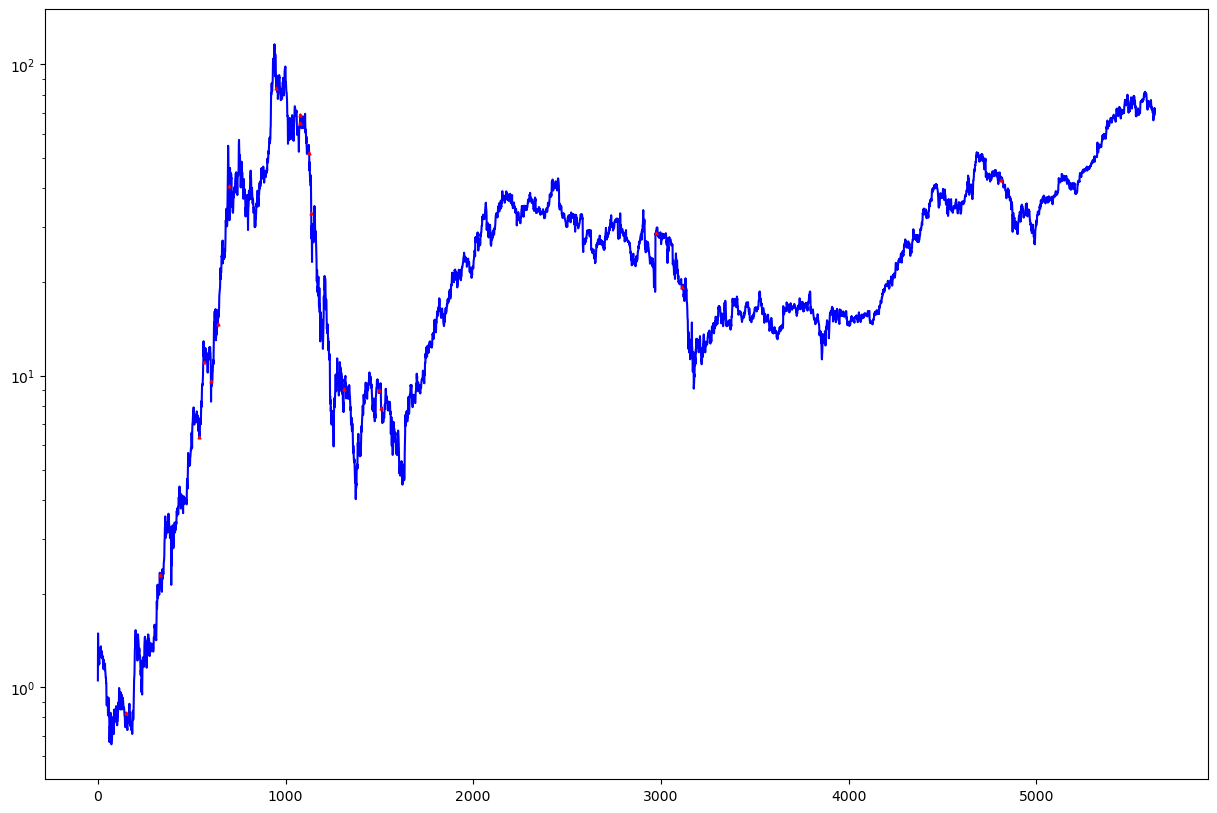

0.48295454545454547


In [198]:
def visualize_pivot_points(pivots,stock):
    plt.plot(range(len(stock.open)),stock.open,color='b',zorder=0)
    for pivot,marker,color in pivots:
        plt.scatter(pivot,stock.open.iloc[pivot],marker=marker,color=color,s=4,zorder=1)
    plt.yscale('log')
    plt.show()

ticker = "AABA"
#20 percent is too much
percent = 15
pivots = combined_filter_strategy(res.loc[(res["Ticker"] == ticker) & (res["Percent"] == percent)]['Train_solution'].iloc[0],ticker400_data[ticker].iloc[int(len(ticker400_data)/4*3)].date,ticker400_data[ticker],n_lagged = 20)
pivots2 = combined_filter_strategy(res_test.loc[(res_test["Ticker"] == ticker) & (res_test["Percent"] == percent)]['Train_solution'].iloc[0],ticker400_data[ticker].iloc[int(len(ticker400_data)/4*3)].date,ticker400_data[ticker],n_lagged = 20)
#pivots=ticker400_trend10["AAPL"]
stock = ticker400_data[ticker]
print(pivots2)
visualize_pivot_points([(pivots2,'^','r')],stock)
print(len(pivots)/len(stock))

In [ ]:
# TODO: i should also try to consolidate pivots that are really close -> invest on the first one


# send 1st pivot in to get the initial trend returns +1 if positive trend or -1 if negative trend
def pivots_to_trend(stock,pivot_computed,procent):
    direction = stock.iloc[pivot_computed[0]] - stock.iloc[0]
    return direction/direction

# we do start capital per stock(not the ideal scenario better to invest in each trade 1% of our capital adn go from there)
def investment_based_on_pivots(start_capital,percent,df,pivots, pivots_computed):
    opens = df.open
    trend = pivots_to_trend(opens,pivots_computed)
    p_p = 0
    c_p = 0
    c_ended = False
    start_invest = -1
    """
    1. preverimo ali je pivot v uptrendu ali v downtrendu na podlagi prejsnih tock in zračunanih pivotov
    2. Preverimo ali smo že investirani
    3a. nismo investirani in smo v downtrendu -> investiramo
    3b. nismo investirani in smo v uptrendu -> ne investiramo
    3c. smo investirani in smo v downtrendu -> ne investiramo
    3d. smo investirani in smo v uptrendu -> zapremo investicijo
    (opcija 3e. smo investirani in smo v mimo uptrenda in presli v downtrend -> zapremo investicijo ali za $procent nižje od izračunanega pivota(failsafe) ali pa ob naslednjem pivotu ki je še znotraj $procent intervala
    """

    while True:


        if not c_ended and pivots[p_p] > pivots_computed[c_p]:
            trend = -trend
            c_p = c_p + 1
            continue
        # invest if uptrend, sell if downtrend
        if pivots[p_p] <=

        # we just end here since we are at the last investment point so we calc the last investment if we are in it
        if p_p == len(pivots):
            pass
        if c_p == len(pivots_computed):
            c_ended = True
            pass
        # we are not invested
        if start_invest == -1:

        # we are invested
        else:
            pass

# we do capital over all stocks




In [164]:
ticker400_data["AABA"].iloc[0].open

numpy.float64

In [143]:
class StratTester:

    # increment type is datetime and represents reinvestment strategy
    def __init__(self, tickers, start_date, strategy, increment = -1, start_capital = 10000, model=None):
        self.tickers = tickers
        self.start_date = start_date
        self.strategy = strategy
        self.capital = [start_capital]
        self.capital_strategy = [start_capital]
        self.capital_buy_and_hold = [start_capital]
        self.investments_buy_and_hold = {}
        # we are not doing increments
        if increment == -1:
            self.incremental = False
        else:
            self.incremental = True
            self.increment = increment
            self.increment_start_date = self.start_date
        if strategy == "ga":
            #model holds params and function model=(params,strategy function)
            pass

    # buy and hold is either equally distributed across all investments or reinvested by a predefined increment the reinvestment is redistributed equally
    # returns the history of our returns
    def buy_and_hold(self):
        investment_per = self.capital_buy_and_hold[-1]/len(self.tickers)
        #print(investment_per)
        self.capital_buy_and_hold.append(0)
        if self.incremental:
            #end_increment is included in the calculation so the reinvestment happens on the same day!
            end_increment = self.increment_start_date + self.increment
            # edge case that end_increment is out of date scope then we just cut off the last week and return it
            if self.tickers[next(iter(self.tickers))]['date'].max() < self.increment_start_date:
                return self.capital_buy_and_hold
            for ticker in self.tickers:
                #print(self.increment_start_date, end_increment)
                increment = self.tickers[ticker].loc[(self.tickers[ticker]['date'] >= self.increment_start_date) & (self.tickers[ticker]['date'] <= end_increment)]
                #print(increment.iloc[0],increment.iloc[-1])
                if len(increment)<=1:
                    self.investments_buy_and_hold[ticker] = investment_per
                else:
                    percent_change = (increment.iloc[-1].open - increment.iloc[0].open) / increment.iloc[0].open
                    #print(percent_change, len(increment))
                    self.investments_buy_and_hold[ticker] = investment_per*percent_change + investment_per
                    #print(self.investments_buy_and_hold)
                    #print(self.investments_buy_and_hold[ticker])
                #if ticker == "MNST":
                    #print(percent_change,ticker,len(increment))
                    #print(increment.iloc[0].open,increment.iloc[-1].open)
                self.capital_buy_and_hold[-1] = self.investments_buy_and_hold[ticker] + self.capital_buy_and_hold[-1]
            self.increment_start_date = end_increment
            return self.buy_and_hold()
        else:
            max = 0
            besto = ""
            for ticker in self.tickers:
                increment = self.tickers[ticker].loc[(self.tickers[ticker]['date'] >= self.start_date)]
                percent_change = (increment.iloc[-1].open - increment.iloc[0].open) / increment.iloc[0].open
                #print(percent_change, investment_per)
                self.capital_buy_and_hold[-1] = self.capital_buy_and_hold[-1] + percent_change * investment_per + investment_per
            return self.capital_buy_and_hold


    def ga_strategy(self):
        pass


In [144]:
#ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date
test = StratTester(ticker400_data,ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date,strategy=None,increment=datetime.timedelta(weeks=1))
test2 = StratTester(ticker400_data,ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date,strategy=None,increment=-1)
print(test.buy_and_hold(),test2.buy_and_hold())

[10000, 10422.23069128498, 10589.055516244296, 10631.942814677128, 10672.39636648369, 10463.293309581572, 10666.926957385664, 11092.532727318636, 11114.335152003194, 11114.471276504559, 11324.17039242137, 11454.365292952667, 11345.581065995613, 11083.816502384136, 11169.965603530525, 11722.461014882541, 11783.264555247499, 12123.040067039063, 12180.793191589824, 12201.754873459144, 11600.680764333383, 11945.31034058404, 11947.517067575409, 12016.33530719462, 12311.368539400084, 12580.901797066248, 12585.168467791122, 12701.218449859334, 12714.670234969999, 13081.687010142992, 13044.93040886564, 13028.9545039173, 13286.960139600986, 13091.35919310418, 13097.156127686705, 12547.179528917273, 12894.988023917887, 12666.180413199096, 12588.121146662323, 12972.04527782429, 13766.031736415722, 13883.221506533195, 13702.030926639654, 13925.449101841112, 13958.573784553877, 14248.550851065878, 14536.57215107516, 14501.228305774197, 14488.923427872003, 14786.906027346446, 15041.45851961398, 1508

Analysis of the distribution per percent and withing ticker

In [ ]:
list(res.iloc[0]["Train_solution"])

In [ ]:
def get_triggers(df,dfY,tick,percent,n_lagged = 20,sty=0):
    def fita(solution, index):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'

        test = df[tick][1][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()
        if sty == 0:
            u0 = ' | ' if solution[36] else ' & '
            u1 = ' | ' if solution[37] else ' & '
            u2 = ' | ' if solution[38] else ' & '
            u3 = ' | ' if solution[39] else ' & '
            u4 = ' | ' if solution[40] else ' & '

            connec = ' | ' if solution[-1] else ' & '

            d0 = ' | ' if solution[41] else ' & '
            d1 = ' | ' if solution[42] else ' & '
            d2 = ' | ' if solution[43] else ' & '
            d3 = ' | ' if solution[44] else ' & '
            d4 = ' | ' if solution[45] else ' & '
            q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
                '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
                '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
                '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
                '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
                '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
                connec +
                '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
                '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
                '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
                '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
                '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
                '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')

            up = test.query(q).index
            res = np.array([False]*len(df[tick][1][n_lagged-1:]))
            res[up] =True


        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

opcije za portofiljo managment:
-pogledamo kakšna je bla smer pred signalom in investiramo če je bla navzdol al pa

In [ ]:
solid_results = pd.DataFrame(columns=['ticker','percent','train_AUC','test_AUC'])
for t in res:
    for p in res[t]:
        solid_results = solid_results.append({'ticker':t,'percent':p,'train_AUC':res[t][p]['train'].last_generation_fitness,'test_AUC':res[t][p]['test']},ignore_index=True)

In [ ]:
res['AABA'][10]["train"].save("./modeli/AABA10")

In [ ]:
print(res['AABA'][10]["train"].best_solutions[-1])

from pathlib import Path
Path("./modeli").mkdir(parents=True, exist_ok=True)
for t in res:
    for p in res[t]:
        path = Path(f"./modeli/{t}{str(p)}")
        if res[t][p]["test"] is not None and Path


Visualise reuslts

In [ ]:
#rabmo 2 subplota enga za train AUC in enga za test AUC in za razilčne procente AUC
results_for_x = [(res[t]['train'].best_solutions_fitness[-1],res[t]['test']) for t in list(ticker400_data)]